# Tutorial 6 - Deprojection to extract energetic contribution to free energy

## Introduction

In this notebook we are going to show how one could construct a 2D free energy surface from the results of umbrella sampling that was only biased in 1D, i.e. along a single CV. Such 'deprojection' will be used/applied to first construct a F(CV,U) free energy surface and then extract the internal energy U(CV) contribution to the original free energy profile F(CV) (which also allows to extract the entropic contribution).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, FreeEnergySurface2D, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D, Histogram2D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.trajectory import ColVarReader, ASEExtendedXYZReader
from thermolib.thermodynamics.condprob import ConditionalProbability1D1D, ConditionalProbability1D2D
from thermolib.units import *

import numpy as np, matplotlib.pyplot as pp, os

In [3]:
prefix = 'advanced_wham1D_to_2D_'
fn_meta = 'data/formic_acid_dimer/wham_input.txt'

## Construct 1D FEP

We first construct the original 1D FEP by means of a regular WHAM analysis.

In [4]:
colvar_reader = ColVarReader([0], units=['au'], end=10000)
temp, bias1d, traj1d = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)

We compute the correlation time between samples of the CV for each trajectory based on the auto correlation function.

/home/lvduyfhu/miniconda3/envs/test/lib/python3.14/site-packages/thermolib/tools.py:960: OptimizeWarning: Covariance of the parameters could not be estimated
  pars, pcovs = curve_fit(function, upper_envelope_indices, upper_envelope_values, **curve_fit_kwargs)


<Figure size 640x480 with 0 Axes>

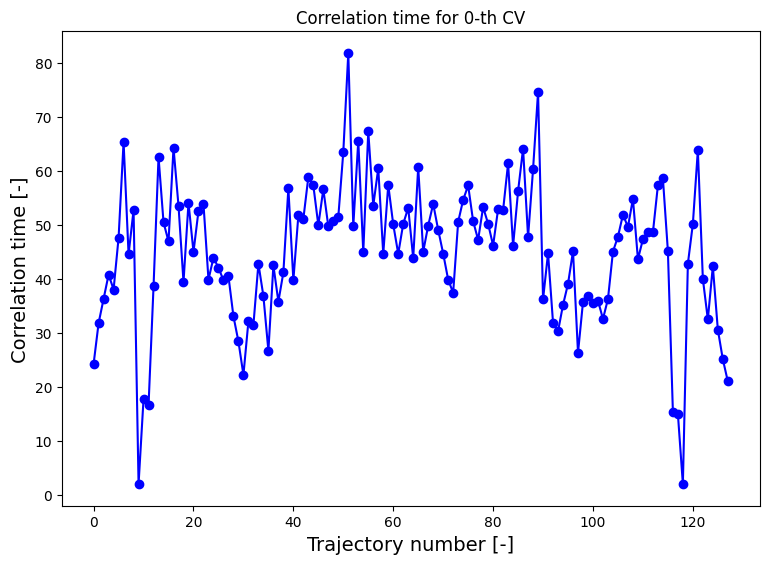

In [5]:
corrtimes_1d = decorrelate(traj1d, plot=True)

Do 1D-WHAM to extract the probability histogram.

In [6]:
bins = np.arange(-1.55, 1.55, 0.05)
hist1d = Histogram1D.from_wham(bins, traj1d, bias1d, temp, error_estimate='mle_f_cov', corrtimes=corrtimes_1d, cv_label='CV', convergence=1e-8, Nscf=20000)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.010s
  bias poten. : 00h 00m 00.003s
  solve scf   : 00h 00m 00.363s
  error est.  : 00h 00m 00.329s
  TOTAL       : 00h 00m 00.707s
---------------------------------------------------------------------


Convert probability histogram to free energy profile. Detect reaction, transition and product states, set the energy reference such that the reactant microstate is at zero energy and plot the results.

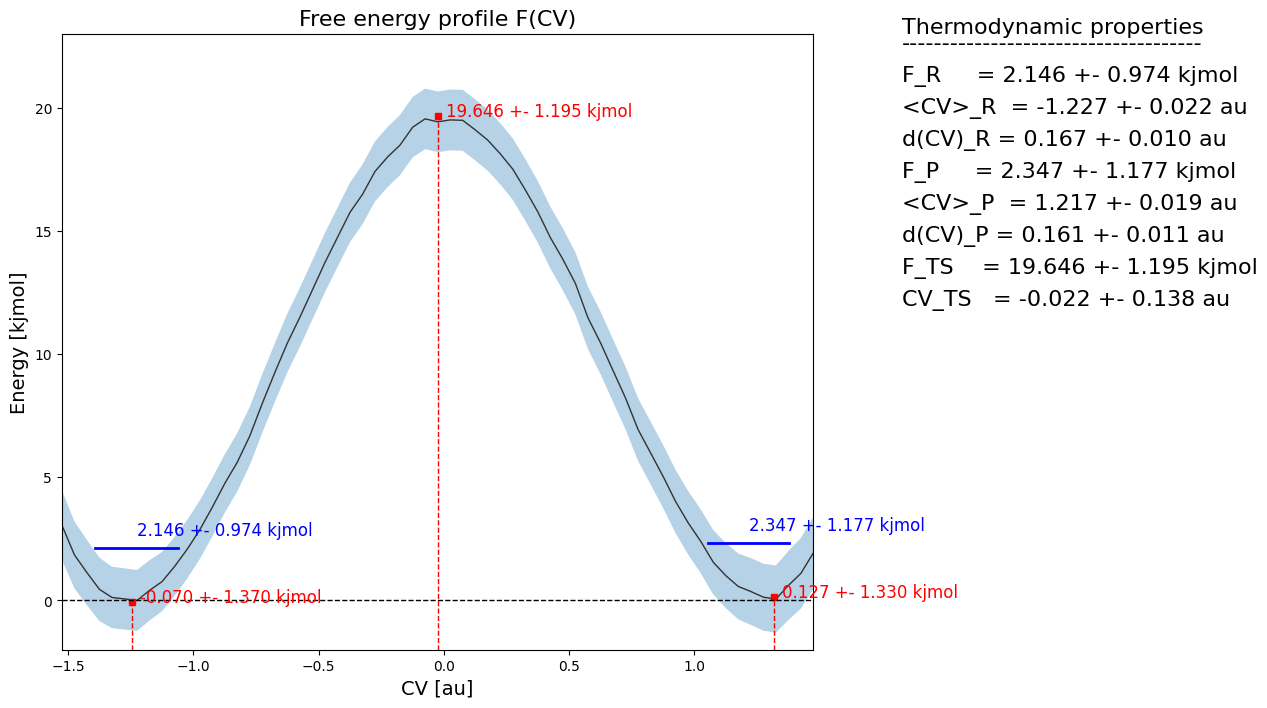

In [7]:
fep = SimpleFreeEnergyProfile.from_histogram(hist1d, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep.set_ref(ref='r')
fep.plot(flims=[-2,23])

## Deproject to 2D FES

In this section, we will construct a 2D free energy surface using the original 1D-biased umbrella simulations using WHAM. The 2D FES is expressed in terms of the original collective variable CV and a new additional collective variable Q chosen as the potential energy U of the total system. This particular choice will later allow to compute the average energy (and its error) as function of the original CV. This in turn allows to interpret the original 1D FEP in terms of its energy and entropy contributions.

Computing the 2D FES can be done in two different ways, which we will both illustrate here and show that they lead to consistent results.
1) The first, more direct, route applies a 2D WHAM analysis to the simulation data in which the originally applied 1D biasing potentials (in terms of CV) are reinterpreted as 2D bias potentials (in terms of CV and Q) that are invariant under the new collective variable Q. 
2) The second route starts from the original 1D FEP and applies a deprojection using the conditional probability distribution p(Q|CV) of the new collective variable Q (i.e. the internal energy) conditional on the old collective variable CV.

### Direct route - 2D WHAM

In [8]:
colvar_reader = ColVarReader([0], units=['au'], end=10000)
extxyz_reader = ASEExtendedXYZReader(['energy'], units=['electronvolt'], reload=True)
temp, bias2d, traj2d = read_wham_input(fn_meta, [colvar_reader,extxyz_reader], ['colvars/COLVAR_%s.dat','colvars/%s.xyz'], kappa1_unit='kjmol', q01_unit='au', bias_potential='Parabola2D')

In order to obtain a convenient range of energies for binning the 2D histogram, the energy values along the trajectory are re-referenced so that the minimum of all means of the simulation is zero.

In [9]:
ref = None
for data in traj2d:
    if ref is None:
        ref = data[:,1].mean()
    else:
        ref = min(ref, data[:,1].mean())
for data in traj2d:
    data[:,1] -= ref

Next we again decorrate data. We therefore assume the correlation time to be equal to the max of the correlation times of both collective variables.

<Figure size 640x480 with 0 Axes>

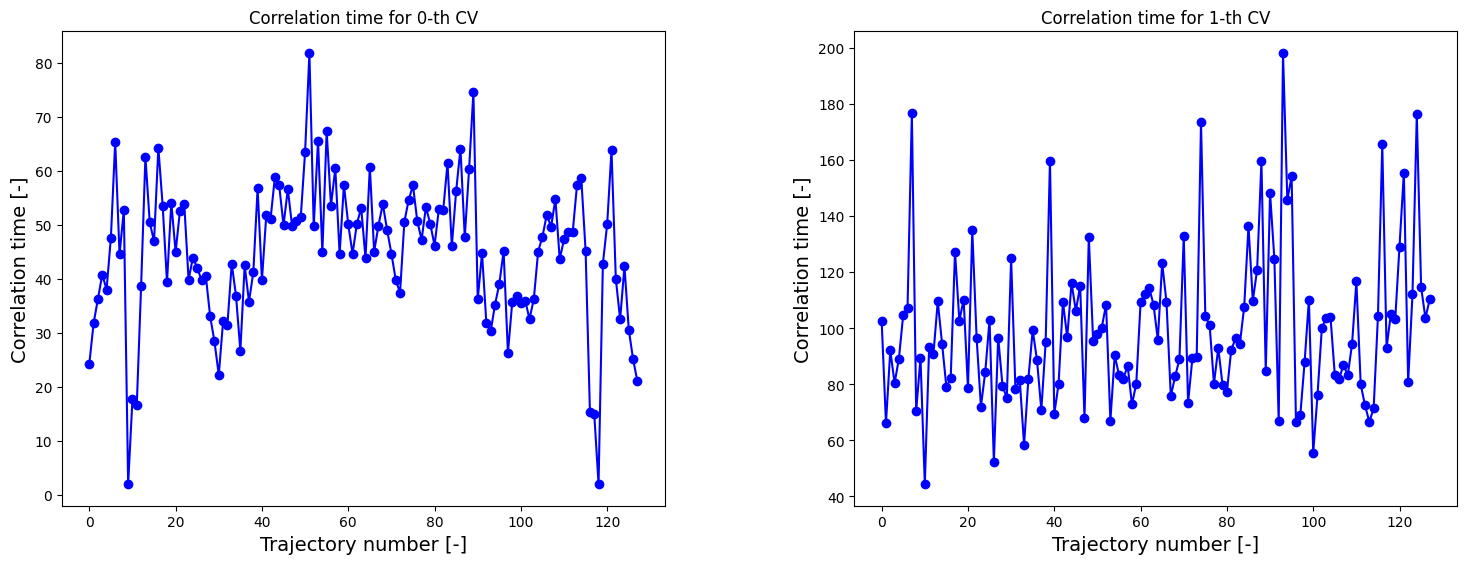

In [10]:
corrtimes_2d = decorrelate(traj2d, plot=True)

We could also approximate the correlation time by that of only one of the collective variables (and hence neglect correlation times of the other collective variable) by using the keyword argument `decorrelate_only`. However, here we proceed with the max of both as computed above.

We take a brief look at the typical range of the second collective variable Q (i.e. the internal energies) to have an idea how to bin its samples.

In [11]:
lower, upper = np.inf, -np.inf
for data in traj2d:
    es = data[:,1]/kjmol
    lower = min(lower, es.mean()-3*es.std())
    upper = max(upper, es.mean()+3*es.std())
print(lower,upper)

-32.31289121104237 50.24649344778027


Based on this range, we bin the energy within [-30,50] kjmol.

In [12]:
bins_cv = np.arange(-1.55, 1.55, 0.05)
bins_u = np.arange(-20, 52.5, 2.5)*kjmol
hist2d1 = Histogram2D.from_wham([bins_cv, bins_u], traj2d, bias2d, temp, error_estimate='mle_f_cov', corrtimes=corrtimes_2d, convergence=1e-7, Nscf=50000, cv2_output_unit='kjmol', cv1_label='CV', cv2_label='U')
fes1 = FreeEnergySurface2D.from_histogram(hist2d1, temp)
fes1.set_ref(ref='min')

  SCF Converged!

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.046s
  bias poten. : 00h 00m 00.344s
  solve scf   : 00h 00m 03.066s
  error est.  : 00h 00m 02.577s
  TOTAL       : 00h 00m 06.035s
---------------------------------------------------------------------


You see that ThermoLIB raised warnings related to not all simulation steps in a given trajectory were properly recognized. This is due to the choice of the bin range, which did not cover the entire simulation data. If you know what you are doing, this is no big issue. ThermoLIB also adjusted the number of simulation steps in each trajectory for accurate determination of the error later on.

Let us now make some 2D contour plots as well as 1D intersection plots of the FES.

<Figure size 640x480 with 0 Axes>

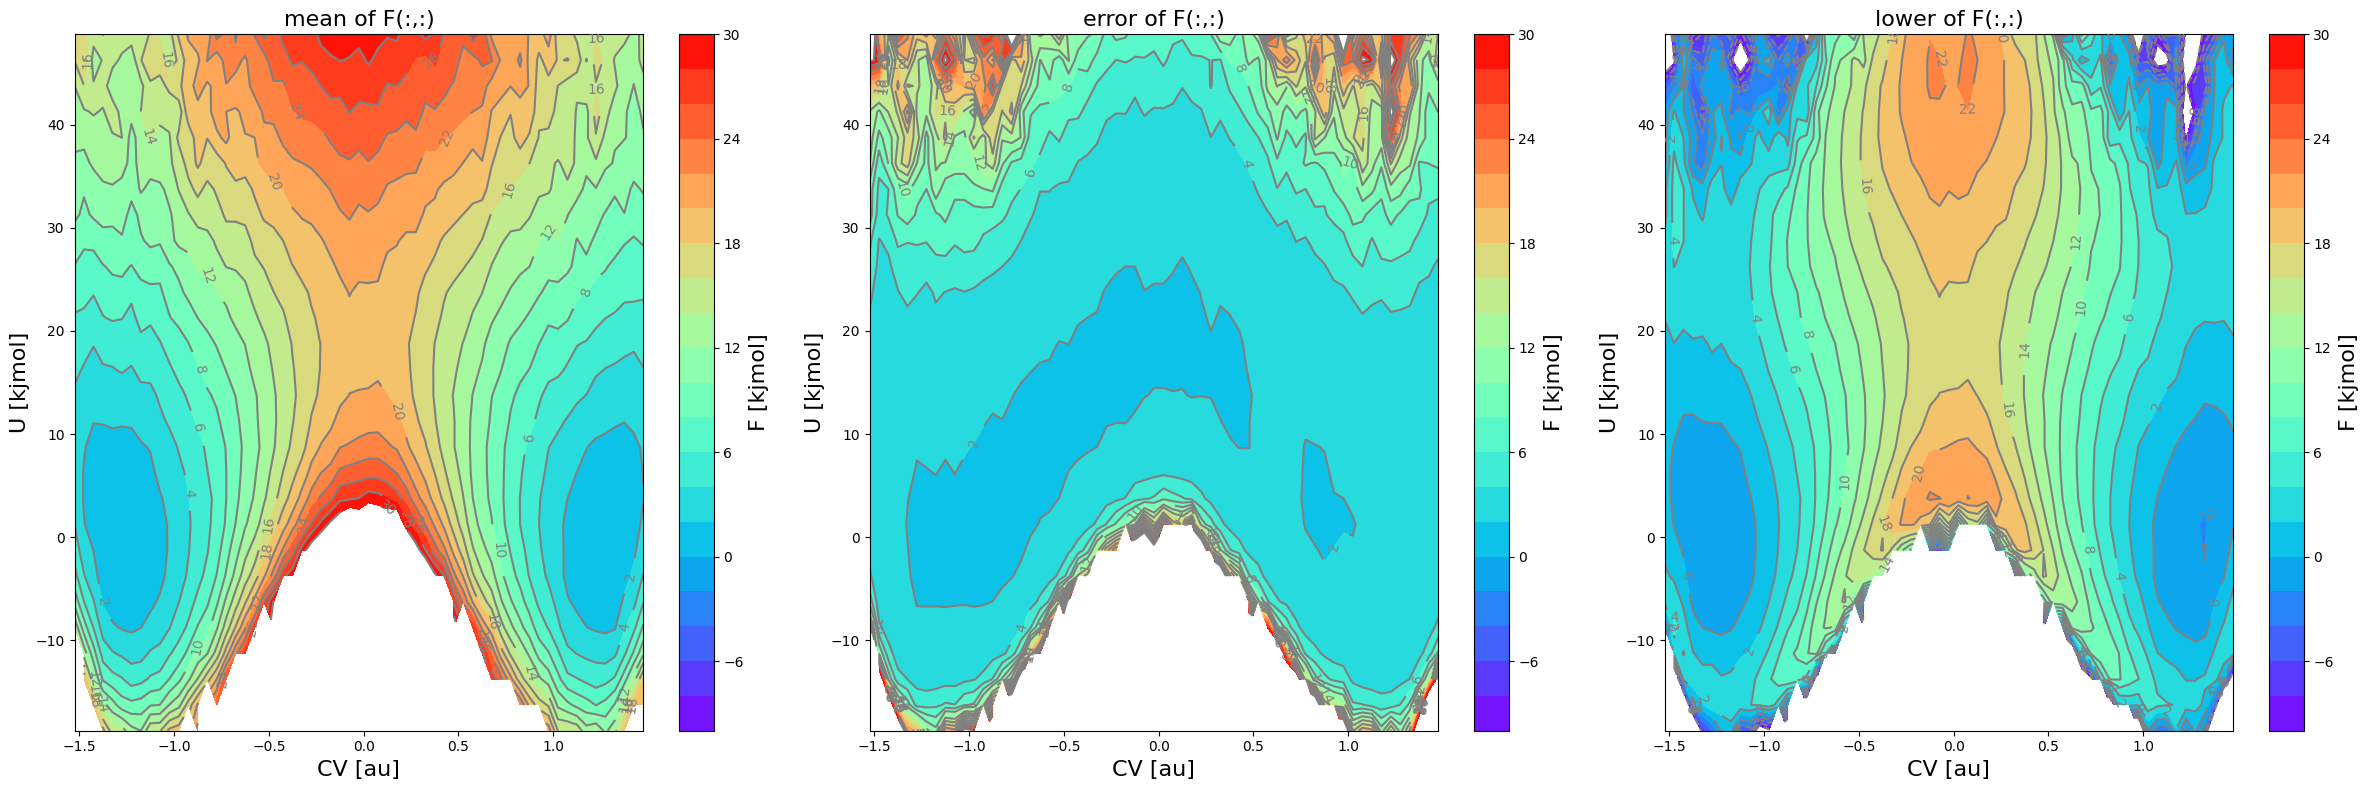

In [13]:
fes1.plot(obss=['mean', 'error', 'lower'], flims=[-10,30], ncolors=20, cmap='rainbow')

#### Deal with the unsufficiently sampled edges of phase space in FES projection

The error (see middle plot) in the region for $U>40\ \text{kJ}.\text{mol}^{-1}$ and $|CV|>0.5$ is so high (more than $20\ \text{kJ}.\text{mol}^{-1}$) that it gives rise to a lower bound for the error interval (see right plot) that is lower than the actual stable reactant state (i.e. lower than $0\ \text{kJ}.\text{mol}^{-1}$). This can poison error propagation as these states will (wrongly) become the dominating states. To prevent this, we can clip off states which almost not sampled in any of the biased simulations by setting the `error_p_thresshold` argument as is done below. Setting `error_p_threshold=0.001` means that any bin in the FES for which there is no single biased simulation in which the biased probability greater than 0.001, will be deactivated for error calculation (i.e. error will not be computed).

In [14]:
bins_cv = np.arange(-1.55, 1.55, 0.05)
bins_u = np.arange(-20, 52.5, 2.5)*kjmol
hist2d1 = Histogram2D.from_wham([bins_cv, bins_u], traj2d, bias2d, temp, error_estimate='mle_f_cov', error_p_threshold=0.001, corrtimes=corrtimes_2d, convergence=1e-7, Nscf=50000, cv2_output_unit='kjmol', cv1_label='CV', cv2_label='U', verbosity='medium')

Initialization ...
Constructing individual histograms for each biased simulation ...
Computing bias on grid ...
Solving WHAM equations (SCF loop) ...
  SCF Converged!
Estimating error ...
  defining zero-mask ...
    deactivated 527 bins
    deactivated 0 sims
  applying zero-mask ...
  inverting Fisher matrix ...

---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.045s
  bias poten. : 00h 00m 00.353s
  solve scf   : 00h 00m 03.128s
  error est.  : 00h 00m 02.267s
  TOTAL       : 00h 00m 05.795s
---------------------------------------------------------------------


In the above logging, you see that there are now more bins deactivated (see statement 'deactivated XX bins' under 'defining zero-mask') indicating that indeed more bins (e.g. those at the edge of the sampled region for which there is no simulations with a sufficiently high biased probability distribution) will be deactivated for estimating the error. This means those phase points will show up blanc in the error related plots.

<Figure size 640x480 with 0 Axes>

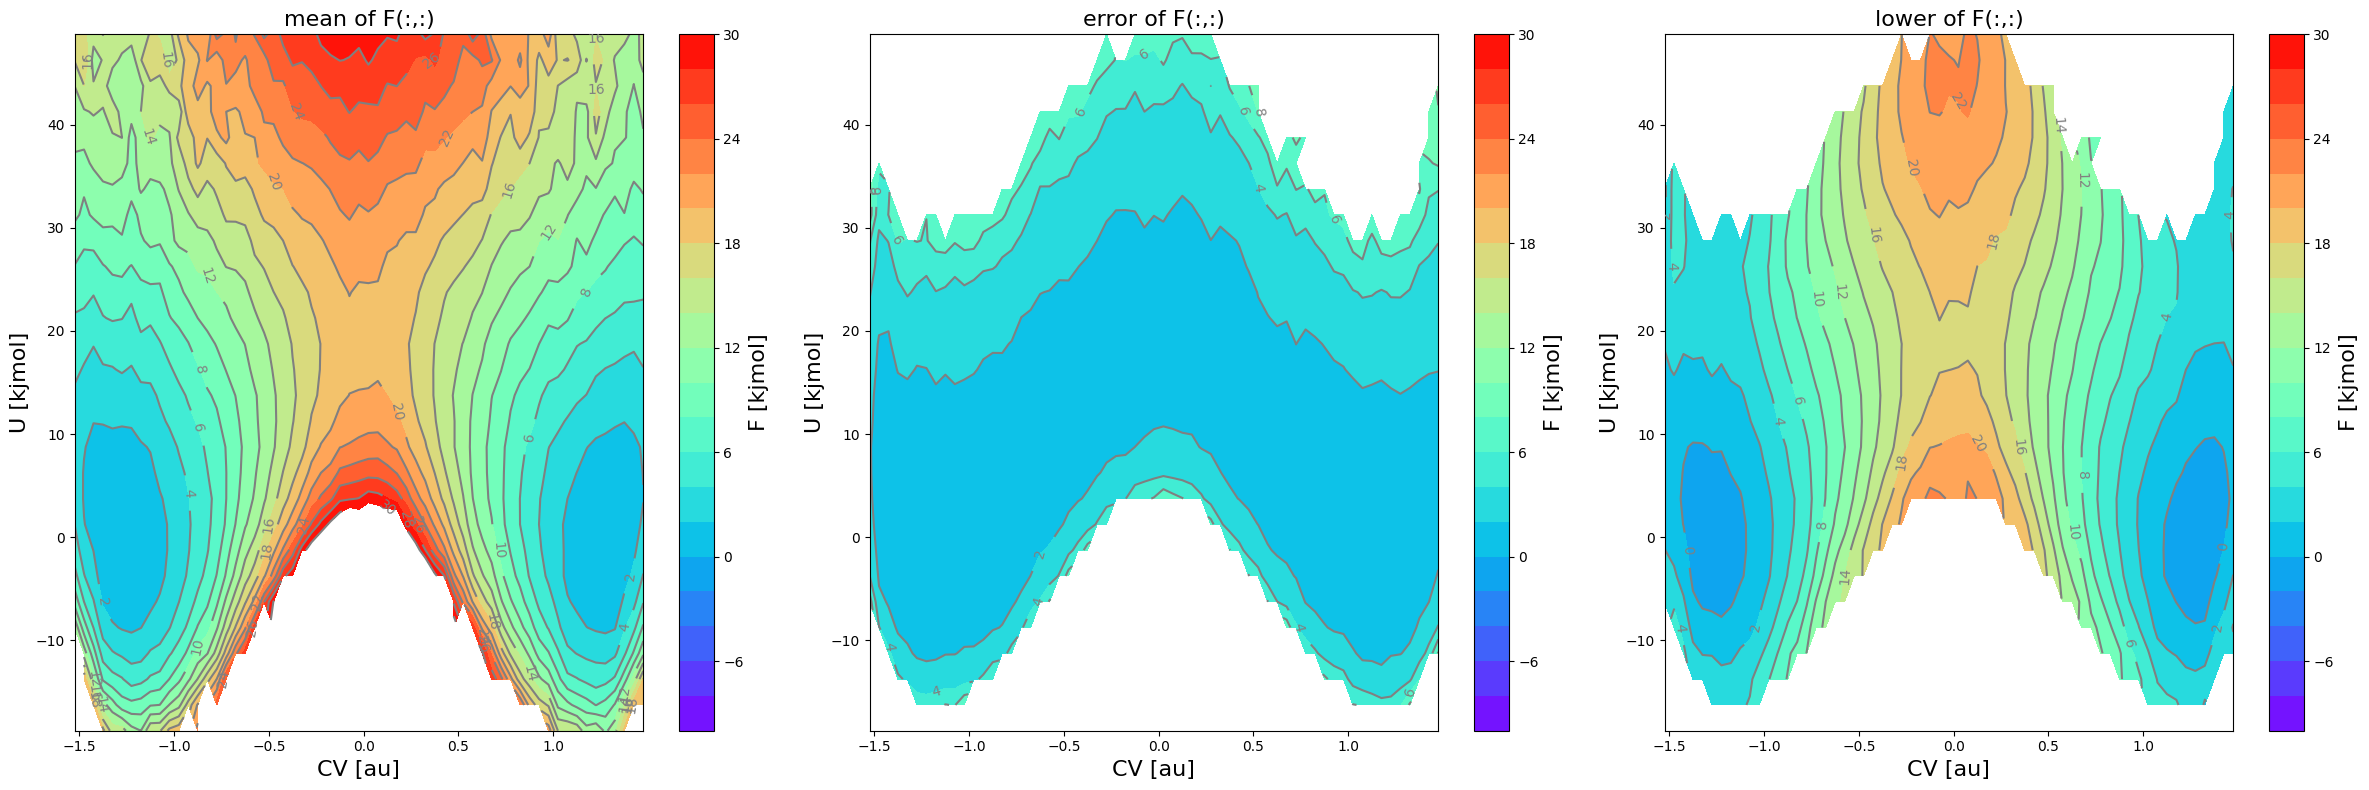

In [15]:
fes1 = FreeEnergySurface2D.from_histogram(hist2d1, temp)
fes1.set_ref(ref='min')
fes1.plot(obss=['mean', 'error', 'lower'], flims=[-10,30], ncolors=20, cmap='rainbow')

In the plot above, you can now clearly see that the states that previously had a lower error bound below 0 kJ/mol are now no longer included in error calculation and hence also no longer have a lower error bound associated to it (it is blanck in the plot).

#### Some additional 1D plots of slices

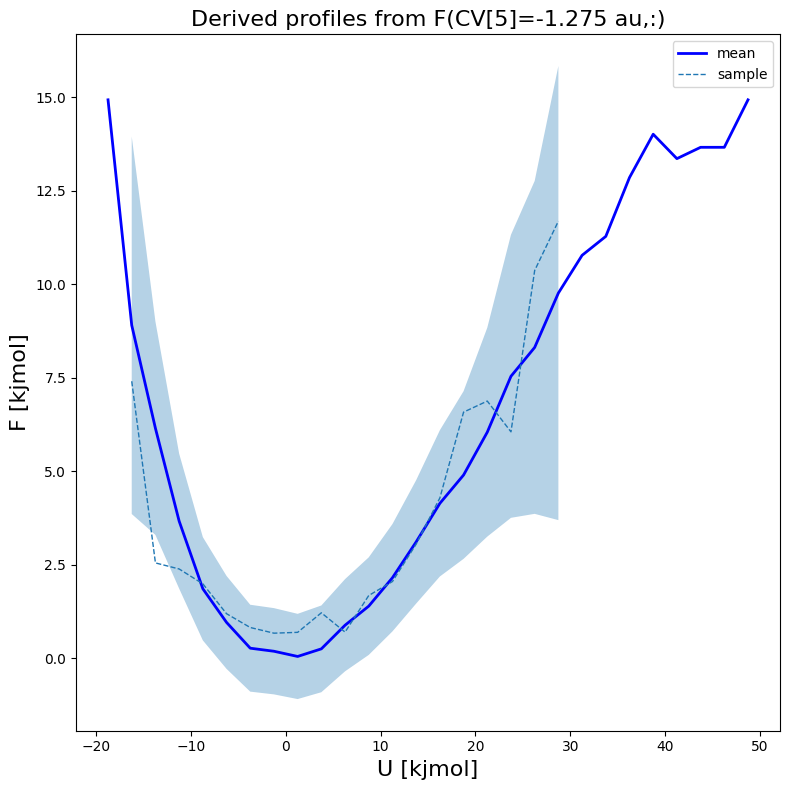

In [16]:
fes1.plot(slicer=[5,slice(None)], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

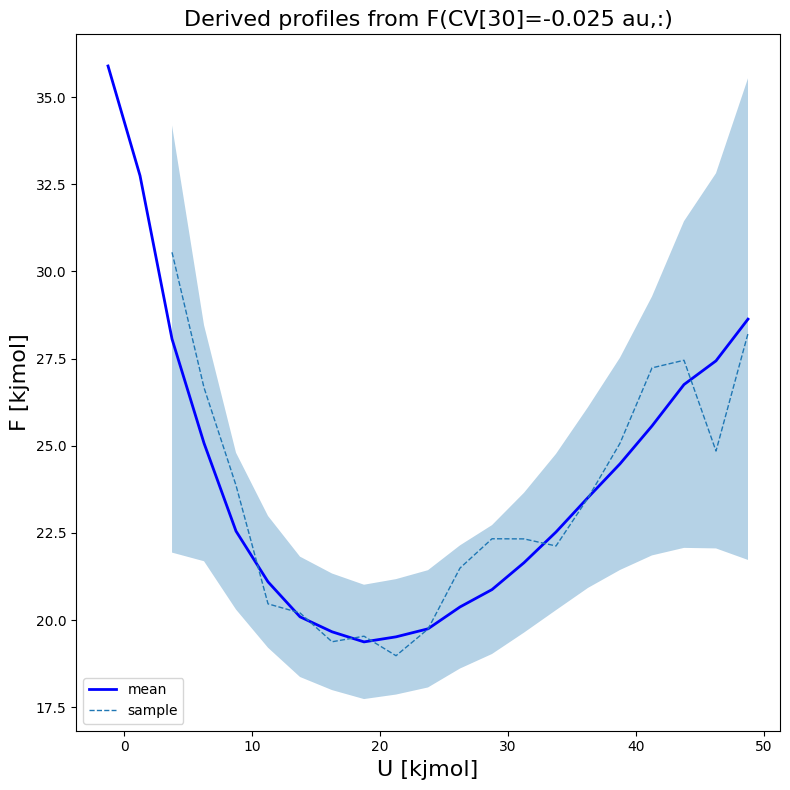

In [17]:
fes1.plot(slicer=[30,slice(None)], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

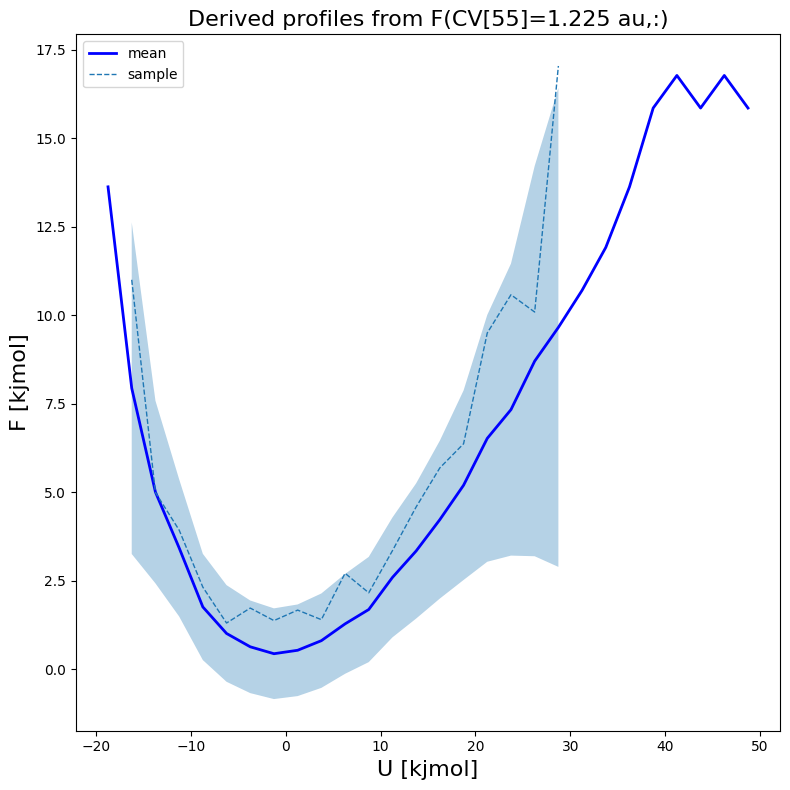

In [18]:
fes1.plot(slicer=[55,slice(None)], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

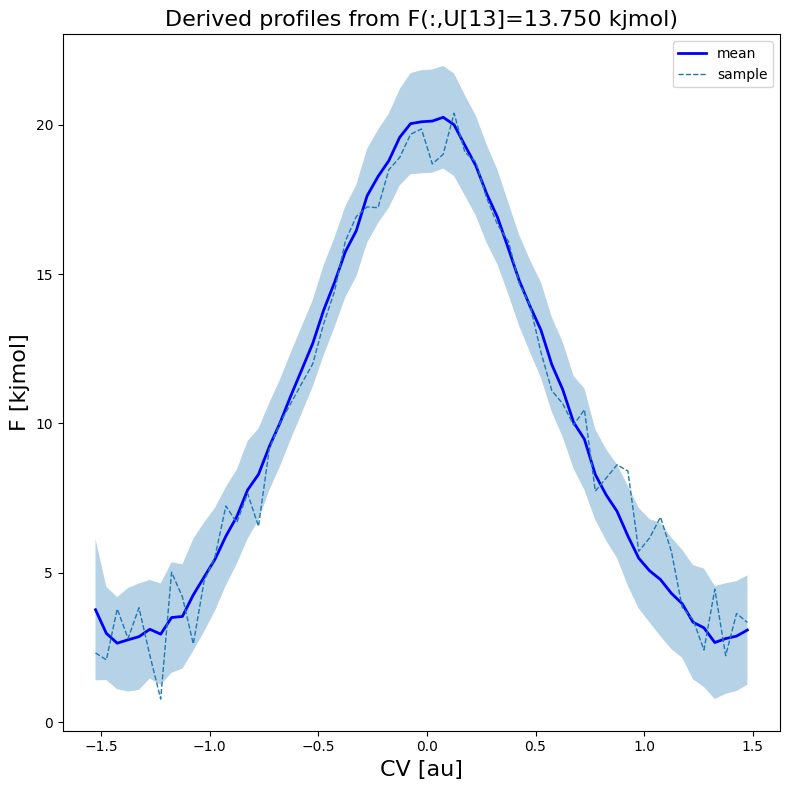

In [19]:
fes1.plot(slicer=[slice(None),13], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

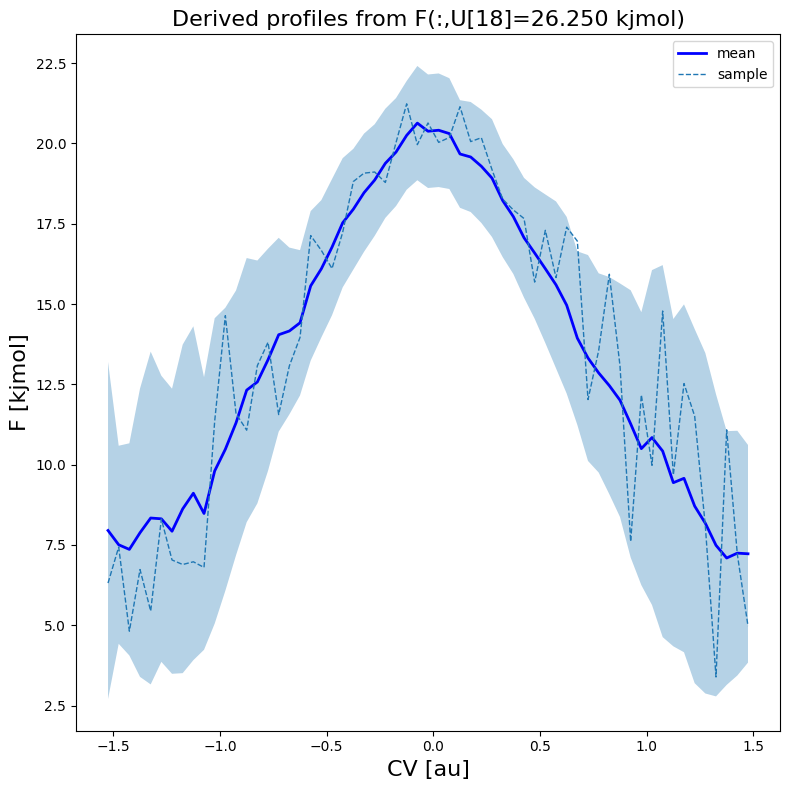

In [20]:
fes1.plot(slicer=[slice(None),18], obss=['mean', 'sample'], linewidths=[2,1], linestyles=['-', '--'], colors=['b',None])

### Indirect route - deproject 1D FEP

In the indirect route, we start from the 1D FEP F(CV) and extract the 2D FES F(CV,U) by means of the following deprojection formula that can be derived from Bayes theorem:

\begin{align}
    P(CV,U) &= P(U|CV)\cdot P(CV) \\
    F(CV,U) &= -k_B T \log\left(P(CV,U)\right) = F(CV) -k_BT \log\left(P(U|CV)\right)
\end{align}

in which $P(CV,U)=e^{-\beta F(CV,U)}$ is the 2D probability histogram related to the desired 2D FES, $P(U|CV)$ is the conditional probability we will need to construct from simulations and $P(CV)=e^{-\beta F(CV)}$ is the original 1D probability histogram related to the original 1D FEP.

In [21]:
#initialize conditional probability
condprob = ConditionalProbability1D1D(q_output_unit='kjmol', cv_output_unit='au', q_label='U')

#initialize TrajectoryReaders to extract CV and Q values from trajectory files
root = os.path.dirname(fn_meta)
cv_reader = ColVarReader([0], units=['au'], name='CV', end=10000)
u_reader = ASEExtendedXYZReader(['energy'], units=['electronvolt'], name='U', reload=True)

#Read trajectory files and construct conditional probability
for i in range(128):
    condprob.process_simulation(
        [('%s/colvars/u%i.xyz'        %(root,i), u_reader )], 
        [('%s/colvars/COLVAR_u%i.dat' %(root,i), cv_reader)], 
        corr_time=corrtimes_2d[i]
    )

In [22]:
#set reference value to minimum of the q-average of each simulation
condprob.set_ref(q_index='all', q_ref='minimum_average')

In [23]:
#finish conditional probability using the specified bin range for U and CV
bins_cv = np.arange(-1.55, 1.55, 0.05)
bins_u = np.arange(-20, 52.5, 2.5)*kjmol
condprob.finish([bins_u], [bins_cv], error_estimate='mle_f_cov', error_p_threshold=0.001)

<Figure size 640x480 with 0 Axes>

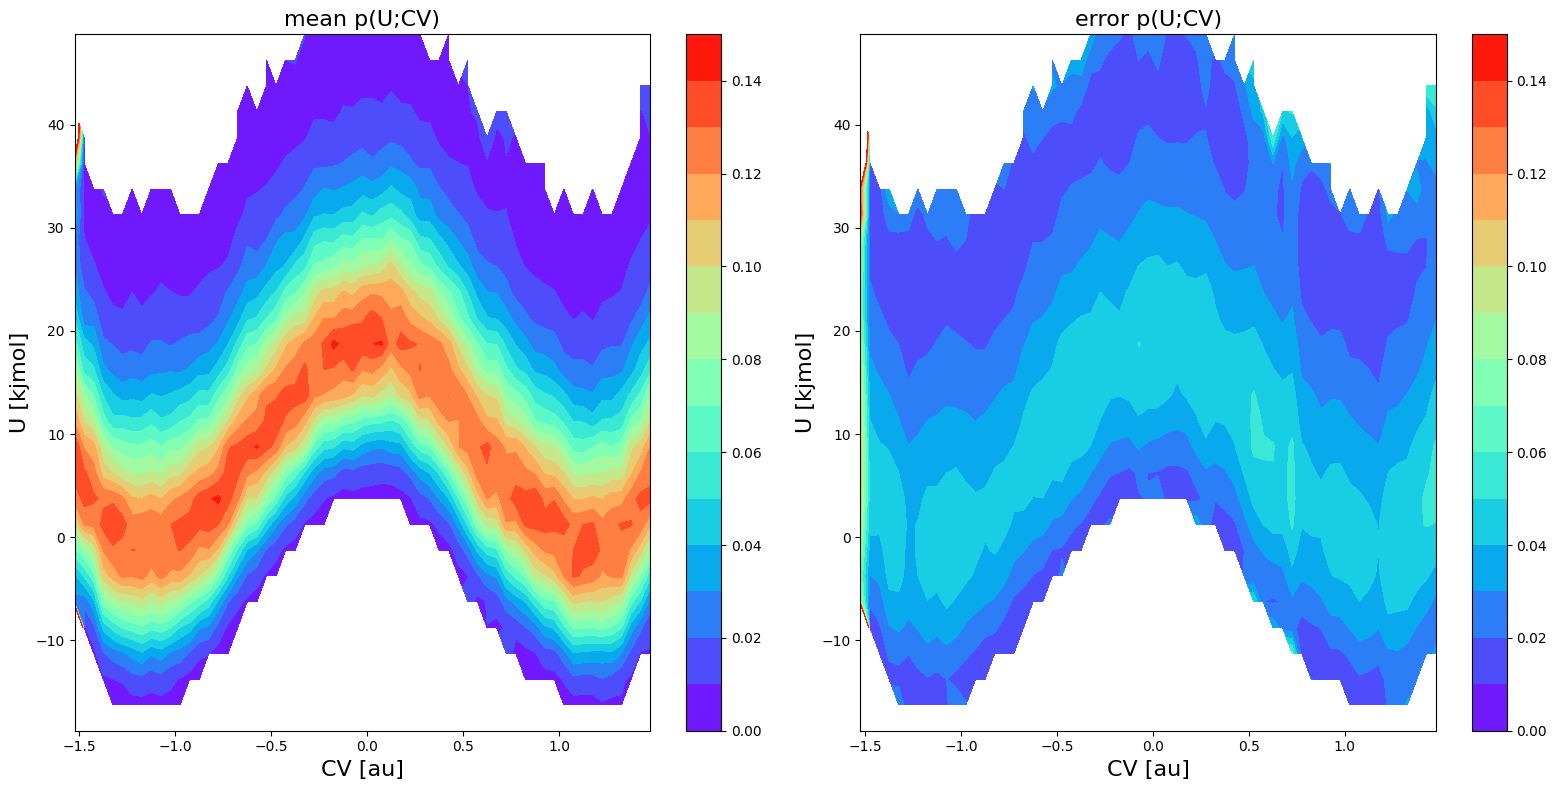

In [24]:
condprob.plot([slice(None), slice(None)], obss=['mean', 'error'], cmap='rainbow', levels=np.linspace(0.0,0.15,16))

In [25]:
fes2 = condprob.deproject(fep)
fes2.set_ref(ref='min')

<Figure size 640x480 with 0 Axes>

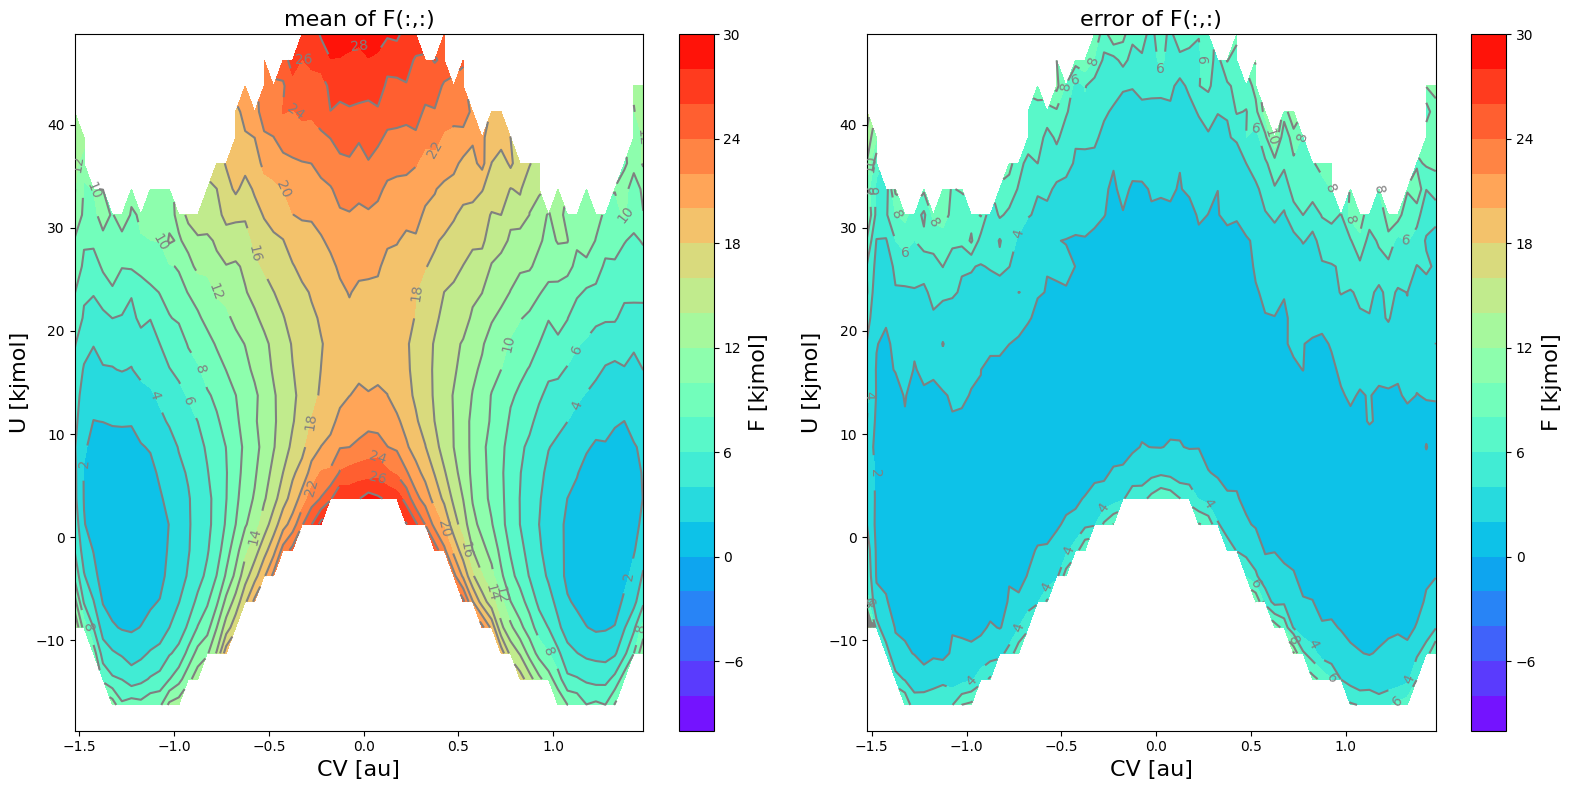

In [26]:
fes2.plot(obss=['mean', 'error'], flims=[-10,30], ncolors=20, cmap='rainbow')

This looks indeed as essentially the same 2D FES as before, except for a (slight) shift in the U values due to slightly different reference that was applied.

#### Alternative deprojection using ConditionalProbability1D2D class

The previous deprojection method was applicable as we wanted to deproject from F(CV) to F(CV,Q), i.e. the original CV was still a CV for the 2D FES. If one wanted to project from F(CV) to F(Q1,Q2), the previous method was not applicable. In that case, one could still do the deprojection using the ConditionalProbability1D2D class. We will illustrate how to use this for the present case as an alternative for the above outlined deprojection method.

In [27]:
#initialize conditional probability
condprob_alt = ConditionalProbability1D2D(q1_label='CV', q2_label='U', cv_label='CV', q1_output_unit='au', q2_output_unit='kjmol', cv_output_unit='au')

#initialize TrajectoryReaders to extract CV and Q values from trajectory files
root = os.path.dirname(fn_meta)
cv_reader = ColVarReader([0], units=['au'], name='CV', end=10000)
u_reader = ASEExtendedXYZReader(['energy'], units=['electronvolt'], name='U', reload=True)

#Read trajectory files and construct conditional probability
for i in range(128):
    condprob_alt.process_simulation(
        [('%s/colvars/COLVAR_u%i.dat' %(root,i), cv_reader), ('%s/colvars/u%i.xyz'        %(root,i), u_reader )], 
        [('%s/colvars/COLVAR_u%i.dat' %(root,i), cv_reader)], 
    )

In [28]:
#set reference value to minimum of the q-average of each simulation
condprob_alt.set_ref(q_index=1, q_ref='minimum_average')

In [29]:
bins_cv = np.arange(-1.55, 1.55, 0.05)
bins_u = np.arange(-20, 52.5, 2.5)*kjmol
condprob_alt.finish([bins_cv,bins_u],[bins_cv])

<Figure size 640x480 with 0 Axes>

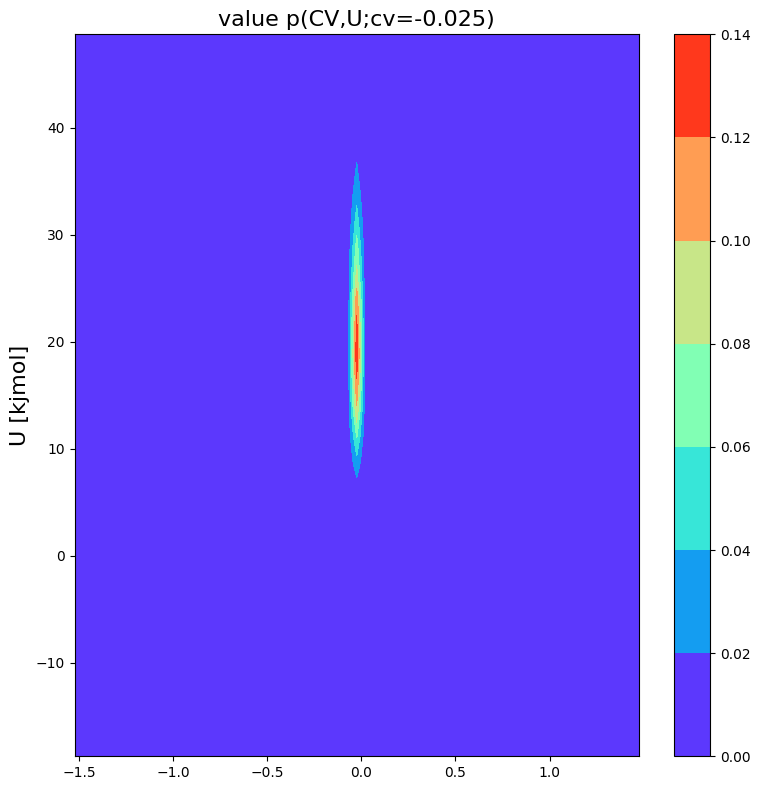

In [30]:
condprob_alt.plot([slice(None),slice(None),30])

<Figure size 640x480 with 0 Axes>

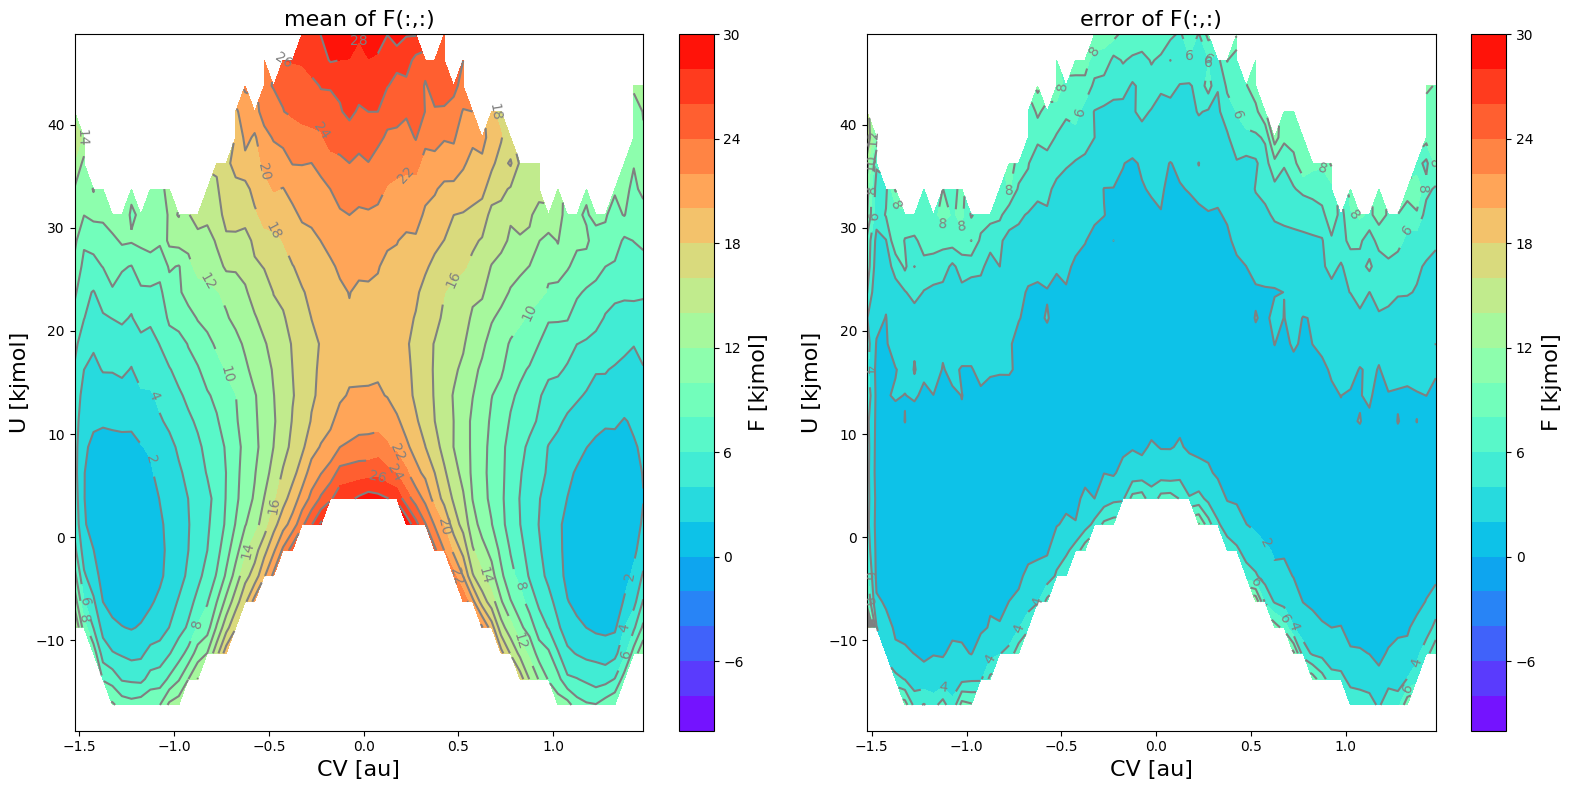

In [31]:
fes2alt = condprob.deproject(fep)
fes2alt.set_ref(ref='min')
fes2alt.plot(obss=['mean', 'error'], flims=[-10,30], ncolors=20, cmap='rainbow')

### CONSISTENCY CHECK: project 2D FES to 1D FEP

As a consistency check, we project the newly constructed 2D FES in terms of CV and U back towards a 1D FEP in terms of CV and compare the results with the original 1D FEP, these should be the same.

In [32]:
fep_from_fes1 = fes1.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_from_fes1.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep_from_fes1.set_ref(ref='r')

In [33]:
fep_from_fes2 = fes2.project_cv1(return_class=SimpleFreeEnergyProfile)
fep_from_fes2.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep_from_fes2.set_ref(ref='r')

<Figure size 640x480 with 0 Axes>

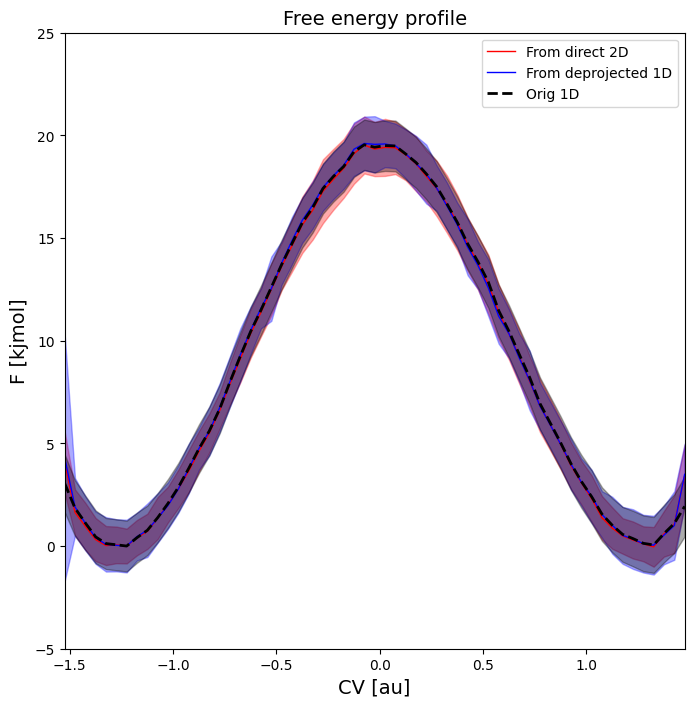

In [34]:
plot_profiles([fep_from_fes1,fep_from_fes2,fep], labels=['From direct 2D','From deprojected 1D','Orig 1D'], colors=['r','b','k'], linestyles=['-','-','--'], linewidths=[1,1,2], flims=[-5,25])

As can be seen, both the direct and indirect methods for computing the 2D FES give rise, upon projecting back on the original CV, to the same 1D profile as the original 1D FEP including its error bar! Below, we also consider the correlations between free energy of different points of the 1D FEP and that is also consistent with the orginal 1D WHAM result!

## U(CV) profile

In this section, we will construct the internal energy contribution to the previously determined Free energy profile. This can again be done in one of two fashions, either by starting from the 2D FES $F(CV,U)$ or by starting from the conditional probability $P(U|CV)$

### Method 1 - from 2D FES

In this first method, we compute the average energy as function of the origal CV from the 2D histogram using the routine ``average_cv_constraint_other``, in which we compute the average of one CV (in this case the internal energy U) while constraining the other (in this case the original CV). For this method, we can use either one of the two previously illustrated method to construct the 2D FES, as they were identical. We choose to use the FES resulting from the direct method, i.e. ``fes2d1`` and corresponding histogram ``hist2d1``.

In [35]:
#compute profile of Us using the histogram hist2 (which encodes probability p(cv,u)) as the average of U (second independent variable in p(cv,u)) as function of CV (first indepedent variable in p(cv,u)):
U_from2d = hist2d1.average_cv_constraint_other(2)
U_from2d.set_ref(ref='min')

### Method 2 - from conditional probability

In the second method, we use the conditional probability directly to again compute the average energy as function of the origal CV using the routine ``average``.

In [36]:
U_fromcond = condprob.average()
U_fromcond.set_ref(ref='min')

### comparison

<Figure size 640x480 with 0 Axes>

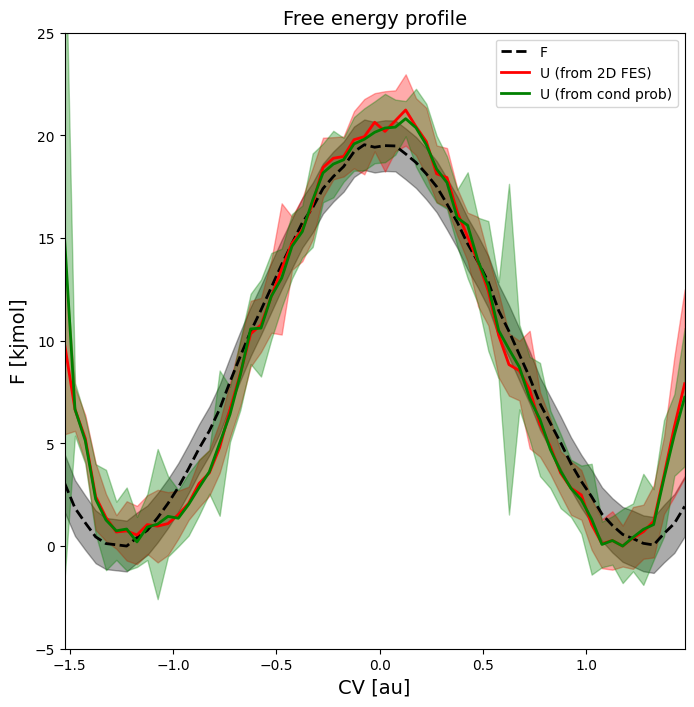

In [37]:
plot_profiles([fep, U_from2d, U_fromcond], labels=['F','U (from 2D FES)', 'U (from cond prob)'], colors=['k', 'r', 'g'], linestyles=['--','-', '-'], flims=[-5,25])

As we can see, the two methods give the same results, only there error bars slightly differ. In this respect, the method using the conditional probability seems to give rise to slightly higher error bars.